# Examing transient and equilibrium climate sensitivity in the CESM 

I have run two sets of experiments with the CESM model:

- The fully coupled model:
    - pre-industrial control
    - 1%/year CO2 ramp scenario for 80 years 
- The slab ocean model:
    - pre-industrial control with prescribed q-flux
    - 2xCO2 scenario run out to equilibrium

Our task today is to compute the two canonical measures of climate sensitivity for this model:

- Equilibrium Climate Sensitivity (ECS)
- Transient Climate Response (TCR)

From the IPCC AR5 WG1 report, Chapter 9, page 817:

> Equilibrium climate sensitivity (ECS) is the equilibrium change in global and annual mean surface air temperature after doubling the atmos- pheric concentration of CO2 relative to pre-industrial levels. 

> The transient climate response (TCR) is the change in global and annual mean surface temperature from an experiment in which the CO2 con- centration is increased by 1% yr–1, and calculated using the difference between the start of the experiment and a 20-year period centred on the time of CO2 doubling. 

### First, a quick demonstration that 1%/year compounded increase reaches doubling after 70 years

In [1]:
startingamount = 1.
amount = startingamount
for n in range(70):
    amount *= 1.01
amount

2.006763368395386

TCR is always smaller than ECS due to the transient effects of ocean heat uptake.

We are going to **estimate** the ECS of the fully coupled model by using the equilibrium response of the Slab Ocean .

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
casenames = {'cpl_control': 'cpl_1850_f19',
             'cpl_CO2ramp': 'cpl_CO2ramp_f19',
             'som_control': 'som_1850_f19',
             'som_2xCO2':   'som_1850_2xCO2',
            }
# The path to the THREDDS server, should work from anywhere
basepath = 'http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/'
# For better performance if you can access the roselab_rit filesystem (e.g. from JupyterHub)
#basepath = '/roselab_rit/cesm_archive/'
casepaths = {}
for name in casenames:
    casepaths[name] = basepath + casenames[name] + '/concatenated/'

In [4]:
# make a dictionary of all the CAM atmosphere output
atm = {}
for name in casenames:
    path = casepaths[name] + casenames[name] + '.cam.h0.nc'
    print('Attempting to open the dataset ', path)
    atm[name] = xr.open_dataset(path, decode_times=False)

Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_CO2ramp_f19/concatenated/cpl_CO2ramp_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/som_1850_f19/concatenated/som_1850_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/som_1850_2xCO2/concatenated/som_1850_2xCO2.cam.h0.nc


In [5]:
# The surface air temperature, which we will use for our sensitivity metrics
atm['cpl_control'].TREFHT

<xarray.DataArray 'TREFHT' (time: 240, lat: 96, lon: 144)>
[3317760 values with dtype=float32]
Coordinates:
  * time     (time) float64 31.0 59.0 90.0 120.0 ... 7.239e+03 7.269e+03 7.3e+03
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

## First problem: compute time series of global, annual mean near-surface air temperature in all four simulations

In [7]:
gw = atm['som_control'].gw

In [8]:
gw

<xarray.DataArray 'gw' (lat: 96)>
array([0.000137, 0.001093, 0.002185, 0.003275, 0.004361, 0.005443, 0.006518,
       0.007587, 0.008647, 0.009697, 0.010737, 0.011765, 0.012781, 0.013782,
       0.014768, 0.015739, 0.016692, 0.017626, 0.018542, 0.019437, 0.020311,
       0.021162, 0.021991, 0.022795, 0.023575, 0.024329, 0.025056, 0.025756,
       0.026427, 0.02707 , 0.027683, 0.028266, 0.028818, 0.029339, 0.029827,
       0.030283, 0.030705, 0.031094, 0.031449, 0.03177 , 0.032056, 0.032307,
       0.032522, 0.032702, 0.032847, 0.032955, 0.033027, 0.033063, 0.033063,
       0.033027, 0.032955, 0.032847, 0.032702, 0.032522, 0.032307, 0.032056,
       0.03177 , 0.031449, 0.031094, 0.030705, 0.030283, 0.029827, 0.029339,
       0.028818, 0.028266, 0.027683, 0.02707 , 0.026427, 0.025756, 0.025056,
       0.024329, 0.023575, 0.022795, 0.021991, 0.021162, 0.020311, 0.019437,
       0.018542, 0.017626, 0.016692, 0.015739, 0.014768, 0.013782, 0.012781,
       0.011765, 0.010737, 0.009697, 0.008

In [9]:
def global_mean(field, weight=gw):
    return (field*weight).mean(dim=('lat','lon'))/weight.mean(dim='lat')

In [11]:
TREFHT_global = {}
for name in casenames:
    TREFHT_global[name] = global_mean(atm[name].TREFHT)

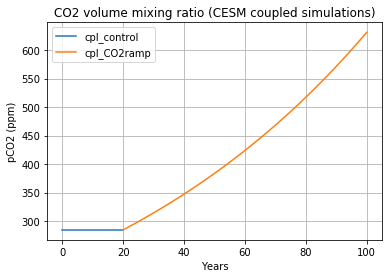

In [12]:
days_per_year = 365
fig, ax = plt.subplots()
for name in ['cpl_control', 'cpl_CO2ramp']:
    ax.plot(atm[name].time/days_per_year, atm[name].co2vmr*1E6, label=name)
ax.set_title('CO2 volume mixing ratio (CESM coupled simulations)')
ax.set_xlabel('Years')
ax.set_ylabel('pCO2 (ppm)')
ax.grid()
ax.legend();

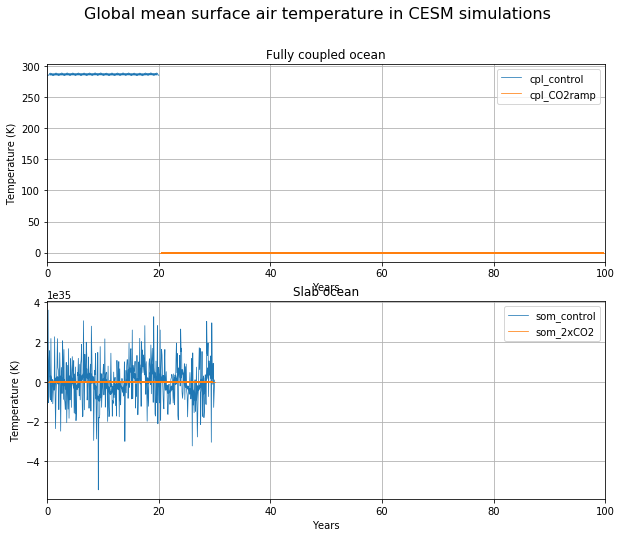

In [13]:
fig, axes = plt.subplots(2,1,figsize=(10,8))
for name in casenames:
    if 'cpl' in name:
        ax = axes[0]
        ax.set_title('Fully coupled ocean')
    else:
        ax = axes[1]
        ax.set_title('Slab ocean')
    field = TREFHT_global[name]
    field_running = field.rolling(time=12, center=True).mean()
    line = ax.plot(field.time / days_per_year, 
                   field, 
                   label=name,
                   linewidth=0.75,
                   )
    ax.plot(field_running.time / days_per_year, 
            field_running, 
            color=line[0].get_color(),
            linewidth=2,
           )
for ax in axes:
    ax.legend();
    ax.set_xlabel('Years')
    ax.set_ylabel('Temperature (K)')
    ax.grid();
    ax.set_xlim(0,100)
fig.suptitle('Global mean surface air temperature in CESM simulations', fontsize=16);

## Now we can work on computing ECS and TCR

## Let's make some maps to compare spatial patterns of transient vs. equilibrium warming

- Maps of annual mean surface air temperature anomalies
- Maps of precipitation?

## Some CMIP climate sensitivity results to compare against

<img src='http://www.climatechange2013.org/images/figures/WGI_AR5_Fig9-43.jpg' width=800>

<img src='../images/AR5_Table9.5.png'>

## For later reference: opening other output types

The following will open the rest of the CESM output (land, sea ice, river routing, ocean)

In [ ]:
# make a dictionary of all the CLM land model output
land = {}
for name in casenames:
    path = casepaths[name] + casenames[name] + '.clm2.h0.nc'
    print('Attempting to open the dataset ', path)
    land[name] = xr.open_dataset(path)

In [ ]:
# make a dictionary of all the sea ice model output
ice = {}
for name in casenames:
    path = casepaths[name] + casenames[name] + '.cice.h.nc'
    print('Attempting to open the dataset ', path)
    ice[name] = xr.open_dataset(path)

In [ ]:
# make a dictionary of all the river transport output
rtm = {}
for name in casenames:
    path = casepaths[name] + casenames[name] + '.rtm.h0.nc'
    print('Attempting to open the dataset ', path)
    rtm[name] = xr.open_dataset(path)

In [ ]:
ocn = {}
for name in casenames:
    if 'cpl' in name:
        path = casepaths[name] + casenames[name] + '.pop.h.nc'
        print('Attempting to open the dataset ', path)
        ocn[name] = xr.open_dataset(path)